In [1]:
import algorithms.train as train
import algorithms.utils as utils
import algorithms.models as models
from enviroments import env_red, env_red_p2p, env_red_toy1, env_hubs1
from algorithms.agents import reinforce, trpo, ppo
import matplotlib.pyplot as plt
import numpy as np
import torch
import gym
import time
import pickle

In [2]:
name_exp = "Exp6"
Red_name = "hub1"
Demand_Model = "Exp" #Puede ser EXP/MNL
Qfun_model = "NN-PG" #Puede ser LR/NN

In [3]:
env = env_hubs1(model="Exp", T=2000)
M = 33
F = 2

#Dimensiónes del espacio de estados
dims_state = list(env.C + 1)
dims_state.append(env.T+1)

#Dimensiones del espacio de acciones
dims_action = [M, F]


In [4]:
actor = models.PolicyNetwork(
    num_inputs=len(dims_state), 
    num_hiddens=[64, 64], 
    num_outputs=[M,F], 
    model="Softmax"
).double()

critc = models.ValueNetwork(
    num_inputs=len(dims_state), 
    num_hiddens=[64, 64], 
    num_outputs=1, 
).double()


In [5]:

agent = reinforce.ReinforceSoftmaxNN(actor, critc, gamma=.99, tau=.99, lr_actor= 1e-6)
Trainer = train.Trainer("sgd", "sgd")


In [6]:
R_exp = []
time_exp = []
qfun_exp = []

start_time = time.time()
agent, totals,_ = Trainer.train(env, agent, epochs=5000, max_steps=2000, update_freq=8000, initial_offset=0)
end_time = time.time()
execution_time = end_time - start_time

R_exp.append(totals)
time_exp.append(execution_time)
qfun_exp.append(agent)

KeyboardInterrupt: 

In [ ]:
import os
# Asegurarse de que el directorio exista, si no existe, créalo
directory = "results/" + name_exp
if not os.path.exists(directory):
    os.makedirs(directory)

exp = {}
exp["R_exp"] = R_exp
exp["Time_exp"] = time_exp
exp["qfun_exp"] = qfun_exp

with open("results/"+ name_exp +"/" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".pickle", 'wb') as f:
    pickle.dump(exp, f)

In [15]:
num_sim = 500
max_steps = 2000
    
Rsim = []
r_t= []
s_t = []
a_t = []

for episode in range(num_sim):
    s, _ = env.set_initial(s = [0]*env.I)
    R = 0
    for step in range(max_steps):

        a = 2**env.J -1

        s_prime, r, done, _, _ = env.step(a)
            
        r_t.append(r)
        s_t.append(s)
        a_t.append(a) 

        R += r

        if done:
            break
                
        s = s_prime
    Rsim.append(R)
    print(f'{episode}/{num_sim}: {R} \r', end='')



In [16]:
with open("results/"+ name_exp +"/" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".pickle", 'rb') as f:
    exp = pickle.load(f)

R_exp = exp["R_exp"]
time_exp = exp["Time_exp"]
qfun_exp = exp["qfun_exp"] 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


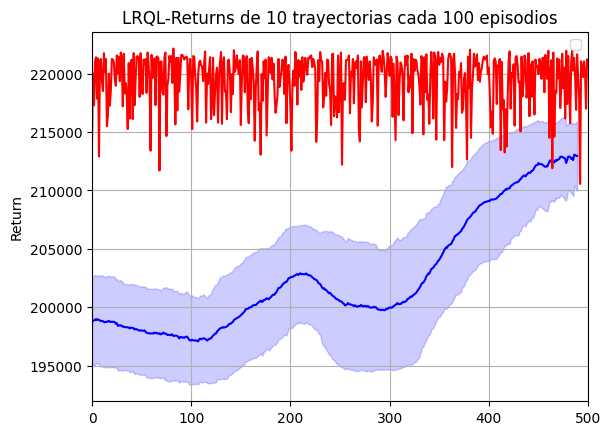

In [20]:
from algorithms.utils import generate_random_colors

colors = generate_random_colors(1)
totals = R_exp[0]
Rs = np.array(totals).ravel()

mean = np.array([np.mean(Rs[i:i+100]) for i in range(len(Rs) - 10)])
std = np.array([np.std(Rs[i:i+100]) for i in range(len(Rs) - 10)])
time = np.arange(mean.size)
plt.plot(mean,color='b')
plt.plot(Rsim, color = 'r')
plt.fill_between(time, mean - std, mean + std, color='b', alpha=0.2)

plt.xlim(0, len(Rs))
plt.grid()
plt.ylabel("Return")
plt.legend()
plt.title("LRQL-Returns de 10 trayectorias cada 100 episodios")
    
plt.savefig("results/"+ name_exp +"/Returns_" +Demand_Model + "_" + Qfun_model +"_" + Red_name +".png")